In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        # Define neural network layers
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        # Output layer for concentration (C)
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Learnable parameters: D and Kd (initially set as trainable parameters)
        self.D = nn.Parameter(
            torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        )  # Diffusion coefficient
        self.Kd = nn.Parameter(
            torch.tensor([10.0], dtype=torch.float32, requires_grad=True)
        )  # Sorption coefficient

        # Loss function and optimizer
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        # Feedforward pass to get concentration profile
        for layer in self.layers:
            x = layer(x)
        return x

    def residual_loss(self, xtrain):
        g = xtrain.clone()
        g.requires_grad = True
        u_pred = self.forward(g)  # Predicted concentration

        # Compute gradients for the residuals
        u_x_t = torch.autograd.grad(
            u_pred,
            g,
            torch.ones([g.shape[0], 1]).to("cuda"),
            retain_graph=True,
            create_graph=True,
        )[0]
        u_xx_tt = torch.autograd.grad(
            u_x_t, g, torch.ones(g.shape).to("cuda"), create_graph=True
        )[0]

        # Diffusion term: u_xx (second spatial derivative)
        u_xx = u_xx_tt[:, [0]]

        # Physics-informed residual (diffusion-sorption-reaction equation)
        residual = u_x_t[:, [1]] - (self.D / (1 + self.Kd)) * u_xx

        return self.loss(
            residual, torch.zeros_like(residual).to("cuda")
        )  # Residual should be zero

    def total_loss(self, xtrain, utrain):
        # Data loss: Compare predicted concentration to true concentration
        data_loss = self.loss(self.forward(xtrain), utrain)

        # Residual loss: Physics-informed
        residual_loss = self.residual_loss(xtrain)

        return data_loss, residual_loss, data_loss + residual_loss

    def train_model(self, xtrain, utrain, epochs=1000):
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            a, b, loss = self.total_loss(xtrain, utrain)
            loss.backward()
            self.optimizer.step()
            if epoch % 200 == 0:
                print(
                    f"Epoch {epoch}, Loss {loss.item()}, D {self.D.item()}, Kd {self.Kd.item()}, Data Loss {a.item()}, Residual Loss {b.item()}"
                )

In [8]:
import h5py

Nx = 100
Nt = 201

with h5py.File("diff_sorp.h5", "r") as f:
    dtrue = f["1"]["D"][()]
    ktrue = f["1"]["Kd"][()]
    C_all = f["1"]["data"][:]
    f.close()
# Create input (x, t) and output (C) tensors
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
X, T = np.meshgrid(x, t)
X_train = torch.tensor(
    np.vstack((X.flatten(), T.flatten())).T, dtype=torch.float32
).to("cuda")
C_train = torch.tensor(C_all.flatten(), dtype=torch.float32).to("cuda")
X_train.shape, C_train.shape

(torch.Size([20100, 2]), torch.Size([20100]))

In [3]:
dtrue, ktrue

(82.44376791378382, 92.0820718580985)

In [9]:
idx = np.random.choice(Nx * Nt, 10000, replace=False)
xtrain = X_train[idx]
C_train = C_train[idx, None]
xtrain.shape, C_train.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [ ]:
model = PINN(2, 20, 1).to("cuda")
model.train_model(xtrain, C_train, epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/shusrith/projects/torch/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 17/10000 [00:00<02:22, 70.10it/s]

Epoch 0, Loss 0.1490456610918045, D 10.00008773803711, Kd 9.999914169311523, Data Loss 0.14904434978961945, Residual Loss 1.3096120028421865e-06


  2%|▏         | 228/10000 [00:01<00:51, 190.86it/s]

Epoch 200, Loss 0.09109816700220108, D 9.9751615524292, Kd 10.024770736694336, Data Loss 0.09107938408851624, Residual Loss 1.878368857433088e-05


  4%|▍         | 434/10000 [00:02<00:47, 202.21it/s]

Epoch 400, Loss 0.087398461997509, D 9.924067497253418, Kd 10.075807571411133, Data Loss 0.08606689423322678, Residual Loss 0.001331567415036261


  6%|▌         | 623/10000 [00:03<00:45, 205.17it/s]

Epoch 600, Loss 0.0810893177986145, D 9.88694953918457, Kd 10.112845420837402, Data Loss 0.08004395663738251, Residual Loss 0.0010453644208610058


  8%|▊         | 830/10000 [00:04<00:45, 199.97it/s]

Epoch 800, Loss 0.07861371338367462, D 9.865224838256836, Kd 10.1344633102417, Data Loss 0.07797321677207947, Residual Loss 0.0006405002204701304


 10%|█         | 1032/10000 [00:05<00:47, 187.65it/s]

Epoch 1000, Loss 0.07791899889707565, D 9.852884292602539, Kd 10.146721839904785, Data Loss 0.07741092145442963, Residual Loss 0.0005080768605694175


 12%|█▏        | 1240/10000 [00:06<00:46, 187.68it/s]

Epoch 1200, Loss 0.07718881964683533, D 9.8414888381958, Kd 10.1580228805542, Data Loss 0.07674388587474823, Residual Loss 0.00044493473251350224


 14%|█▍        | 1424/10000 [00:07<00:42, 199.73it/s]

Epoch 1400, Loss 0.07597218453884125, D 9.83272647857666, Kd 10.166709899902344, Data Loss 0.07558586448431015, Residual Loss 0.0003863235760945827


 16%|█▌        | 1619/10000 [00:08<00:45, 183.89it/s]

Epoch 1600, Loss 0.07474730163812637, D 9.820060729980469, Kd 10.179242134094238, Data Loss 0.07436849176883698, Residual Loss 0.00037880701711401343


 18%|█▊        | 1825/10000 [00:09<00:41, 198.82it/s]

Epoch 1800, Loss 0.07365554571151733, D 9.790755271911621, Kd 10.208234786987305, Data Loss 0.0732254609465599, Residual Loss 0.0004300862201489508


 20%|██        | 2028/10000 [00:10<00:41, 193.03it/s]

Epoch 2000, Loss 0.07335983216762543, D 9.759184837341309, Kd 10.239486694335938, Data Loss 0.07307765632867813, Residual Loss 0.0002821786911226809


 22%|██▏       | 2228/10000 [00:11<00:41, 185.51it/s]

Epoch 2200, Loss 0.07317162305116653, D 9.729416847229004, Kd 10.26894474029541, Data Loss 0.07292569428682327, Residual Loss 0.00024592666886746883


 24%|██▍       | 2441/10000 [00:12<00:39, 192.51it/s]

Epoch 2400, Loss 0.07292401045560837, D 9.701478958129883, Kd 10.296576499938965, Data Loss 0.07266438752412796, Residual Loss 0.00025962598738260567


 26%|██▋       | 2626/10000 [00:13<00:38, 191.63it/s]

Epoch 2600, Loss 0.07251635193824768, D 9.674617767333984, Kd 10.323152542114258, Data Loss 0.07219450175762177, Residual Loss 0.00032184849260374904


 28%|██▊       | 2833/10000 [00:15<00:35, 202.65it/s]

Epoch 2800, Loss 0.07213422656059265, D 9.648120880126953, Kd 10.349349975585938, Data Loss 0.07175631821155548, Residual Loss 0.00037790712667629123


 30%|███       | 3036/10000 [00:16<00:35, 196.86it/s]

Epoch 3000, Loss 0.07172473520040512, D 9.623099327087402, Kd 10.374070167541504, Data Loss 0.07137463241815567, Residual Loss 0.0003501008031889796


 32%|███▏      | 3238/10000 [00:17<00:36, 187.02it/s]

Epoch 3200, Loss 0.07124891132116318, D 9.599546432495117, Kd 10.397320747375488, Data Loss 0.07096093147993088, Residual Loss 0.0002879829262383282


 34%|███▍      | 3427/10000 [00:18<00:36, 181.70it/s]

Epoch 3400, Loss 0.07070966064929962, D 9.577367782592773, Kd 10.41919231414795, Data Loss 0.07046695798635483, Residual Loss 0.0002427014260319993


 36%|███▋      | 3631/10000 [00:19<00:36, 172.65it/s]

Epoch 3600, Loss 0.07021962106227875, D 9.556498527526855, Kd 10.439769744873047, Data Loss 0.06990986317396164, Residual Loss 0.00030975526897236705


 38%|███▊      | 3818/10000 [00:20<00:36, 171.38it/s]

Epoch 3800, Loss 0.06977704912424088, D 9.536181449890137, Kd 10.459798812866211, Data Loss 0.06953045725822449, Residual Loss 0.0002465905563440174


 40%|████      | 4029/10000 [00:21<00:30, 196.78it/s]

Epoch 4000, Loss 0.06958024203777313, D 9.515456199645996, Kd 10.480223655700684, Data Loss 0.06930210441350937, Residual Loss 0.0002781377697829157


 42%|████▏     | 4228/10000 [00:22<00:31, 184.65it/s]

Epoch 4200, Loss 0.06944503635168076, D 9.494409561157227, Kd 10.500975608825684, Data Loss 0.06919809430837631, Residual Loss 0.00024694210151210427


 44%|████▍     | 4425/10000 [00:23<00:28, 192.54it/s]

Epoch 4400, Loss 0.06947007030248642, D 9.473309516906738, Kd 10.521758079528809, Data Loss 0.0691918209195137, Residual Loss 0.00027824798598885536


 46%|████▋     | 4625/10000 [00:24<00:30, 173.40it/s]

Epoch 4600, Loss 0.06929292529821396, D 9.452305793762207, Kd 10.54246997833252, Data Loss 0.06904222071170807, Residual Loss 0.00025070112315006554


 48%|████▊     | 4832/10000 [00:25<00:25, 202.73it/s]

Epoch 4800, Loss 0.06932280957698822, D 9.431513786315918, Kd 10.562966346740723, Data Loss 0.06909562647342682, Residual Loss 0.00022718588297720999


 50%|█████     | 5037/10000 [00:26<00:25, 191.45it/s]

Epoch 5000, Loss 0.06918328255414963, D 9.410831451416016, Kd 10.583340644836426, Data Loss 0.06898213177919388, Residual Loss 0.00020115422375965863


 52%|█████▏    | 5218/10000 [00:27<00:25, 190.35it/s]

Epoch 5200, Loss 0.06914213299751282, D 9.390336990356445, Kd 10.603537559509277, Data Loss 0.06894739717245102, Residual Loss 0.0001947388082044199


 54%|█████▍    | 5439/10000 [00:29<00:23, 195.58it/s]

Epoch 5400, Loss 0.06910697370767593, D 9.369949340820312, Kd 10.6235933303833, Data Loss 0.06891731917858124, Residual Loss 0.0001896542526083067


 56%|█████▋    | 5625/10000 [00:30<00:22, 194.73it/s]

Epoch 5600, Loss 0.06907440721988678, D 9.349642753601074, Kd 10.643549919128418, Data Loss 0.06888903677463531, Residual Loss 0.00018536712741479278


 58%|█████▊    | 5824/10000 [00:31<00:21, 197.96it/s]

Epoch 5800, Loss 0.06904394924640656, D 9.32939624786377, Kd 10.663496017456055, Data Loss 0.06885933876037598, Residual Loss 0.0001846104860305786


 60%|██████    | 6041/10000 [00:32<00:20, 192.99it/s]

Epoch 6000, Loss 0.06901531666517258, D 9.309184074401855, Kd 10.68334674835205, Data Loss 0.06883755326271057, Residual Loss 0.00017776255845092237


 62%|██████▏   | 6224/10000 [00:33<00:18, 200.69it/s]

Epoch 6200, Loss 0.06898908317089081, D 9.289023399353027, Kd 10.703164100646973, Data Loss 0.06880655139684677, Residual Loss 0.00018253129383083433


 64%|██████▍   | 6430/10000 [00:34<00:19, 187.35it/s]

Epoch 6400, Loss 0.06896676123142242, D 9.268943786621094, Kd 10.722930908203125, Data Loss 0.06878431141376495, Residual Loss 0.0001824461214710027


 66%|██████▌   | 6623/10000 [00:35<00:18, 183.58it/s]

Epoch 6600, Loss 0.06893832236528397, D 9.2489013671875, Kd 10.742652893066406, Data Loss 0.06876572221517563, Residual Loss 0.00017260371532756835


 68%|██████▊   | 6837/10000 [00:36<00:16, 188.69it/s]

Epoch 6800, Loss 0.06891467422246933, D 9.228864669799805, Kd 10.762345314025879, Data Loss 0.06874331831932068, Residual Loss 0.00017135623784270138


 70%|███████   | 7032/10000 [00:37<00:15, 192.81it/s]

Epoch 7000, Loss 0.06889193505048752, D 9.208855628967285, Kd 10.782007217407227, Data Loss 0.06872967630624771, Residual Loss 0.00016225516446866095


 72%|███████▏  | 7237/10000 [00:38<00:13, 201.05it/s]

Epoch 7200, Loss 0.06889039278030396, D 9.1888427734375, Kd 10.801655769348145, Data Loss 0.06875772774219513, Residual Loss 0.00013266754103824496


 74%|███████▍  | 7430/10000 [00:39<00:14, 180.65it/s]

Epoch 7400, Loss 0.0688481554389, D 9.168841361999512, Kd 10.821310997009277, Data Loss 0.06868382543325424, Residual Loss 0.00016433140262961388


 76%|███████▌  | 7621/10000 [00:40<00:12, 183.86it/s]

Epoch 7600, Loss 0.06882521510124207, D 9.148855209350586, Kd 10.840951919555664, Data Loss 0.06865222007036209, Residual Loss 0.0001729952491587028


 78%|███████▊  | 7835/10000 [00:41<00:11, 185.70it/s]

Epoch 7800, Loss 0.06880325824022293, D 9.128896713256836, Kd 10.860563278198242, Data Loss 0.06863753497600555, Residual Loss 0.00016572322056163102


 80%|████████  | 8038/10000 [00:42<00:10, 193.80it/s]

Epoch 8000, Loss 0.06878206878900528, D 9.108951568603516, Kd 10.880160331726074, Data Loss 0.06861666589975357, Residual Loss 0.00016540006618015468


 82%|████████▏ | 8231/10000 [00:44<00:09, 180.98it/s]

Epoch 8200, Loss 0.06876087188720703, D 9.088980674743652, Kd 10.899775505065918, Data Loss 0.06859590113162994, Residual Loss 0.00016497174510732293


 84%|████████▍ | 8419/10000 [00:45<00:09, 165.45it/s]

Epoch 8400, Loss 0.06874086707830429, D 9.06899356842041, Kd 10.919403076171875, Data Loss 0.06857053935527802, Residual Loss 0.00017032895993907005


 86%|████████▌ | 8624/10000 [00:46<00:07, 177.80it/s]

Epoch 8600, Loss 0.06871862709522247, D 9.049023628234863, Kd 10.939011573791504, Data Loss 0.06855426728725433, Residual Loss 0.00016436129226349294


 88%|████████▊ | 8827/10000 [00:47<00:06, 185.20it/s]

Epoch 8800, Loss 0.0686986967921257, D 9.0291166305542, Kd 10.95858097076416, Data Loss 0.06852759420871735, Residual Loss 0.000171099862200208


 90%|█████████ | 9026/10000 [00:48<00:05, 190.37it/s]

Epoch 9000, Loss 0.06867983937263489, D 9.009140968322754, Kd 10.978198051452637, Data Loss 0.06849774718284607, Residual Loss 0.00018208958499599248


 92%|█████████▏| 9237/10000 [00:49<00:04, 175.09it/s]

Epoch 9200, Loss 0.06865619122982025, D 8.989139556884766, Kd 10.997828483581543, Data Loss 0.0684954896569252, Residual Loss 0.00016070353740360588


 94%|█████████▍| 9434/10000 [00:50<00:03, 178.87it/s]

Epoch 9400, Loss 0.06863518059253693, D 8.969138145446777, Kd 11.017460823059082, Data Loss 0.068471260368824, Residual Loss 0.00016391818644478917


 96%|█████████▋| 9632/10000 [00:52<00:02, 167.45it/s]

Epoch 9600, Loss 0.06861433386802673, D 8.949151992797852, Kd 11.03708553314209, Data Loss 0.06844985485076904, Residual Loss 0.00016448013775516301


 98%|█████████▊| 9829/10000 [00:53<00:01, 159.44it/s]

Epoch 9800, Loss 0.06859339028596878, D 8.929143905639648, Kd 11.05672550201416, Data Loss 0.06842928379774094, Residual Loss 0.00016410715761594474


100%|██████████| 10000/10000 [00:54<00:00, 183.33it/s]


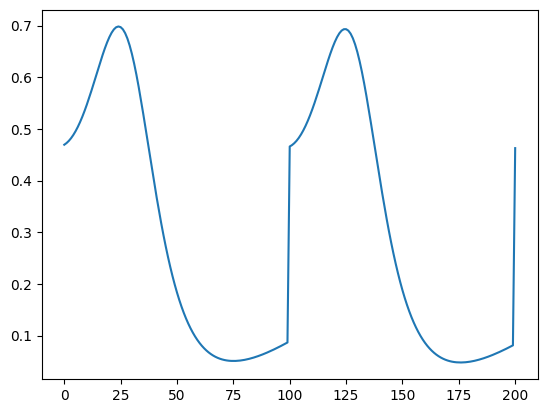

In [11]:
import matplotlib.pyplot as plt

with torch.no_grad():
    C_pred = model.forward(X_train).cpu().numpy()
    C_pred = C_pred.reshape((Nx, Nt))
    plt.plot(C_pred[0], label="Predicted")
    plt.show()